<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/inverseProblems/wienerFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Wiener filtering
###David Brady
### University of Arizona

Section 3.2 of **Computational Imaging**

This notebook considers examples of Wiener filtering for signal estimation. Assume that the expected value of the signal to noise ratio is uniform and independent of frequency, in which case the Wiener filter is
$$
w(u)=\frac{{\hat h}^\ast (u) {\rm SNR}}{|{\hat h} (u)|^2 {\rm SNR} +1}
$$

### Python modules

In [185]:
import numpy as np
from skimage import io
from skimage import color, data, restoration, exposure
from scipy.signal import convolve2d, convolve
from scipy.signal import bspline
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 22})

### Installation of the Chianti database of astrophysical data

CHIANTI consists of a database of atomic data that can be used to interpret spectral lines and continua emitted from high-temperature, optically-thin astrophysical sources. For more information see [the database github page](https://chianti-atomic.github.io/index.html) We use the database here to generate example 1D signals

In [13]:
!wget https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
!mkdir dbase
!tar xvf CHIANTI_10.0.1_database.tar.gz -C dbase/

--2021-05-31 19:11:20--  https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
Resolving download.chiantidatabase.org (download.chiantidatabase.org)... 70.32.23.63
Connecting to download.chiantidatabase.org (download.chiantidatabase.org)|70.32.23.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888202017 (847M) [application/x-gzip]
Saving to: ‘CHIANTI_10.0.1_database.tar.gz’

CHIANTI_10.0.1_data 100%[===================>] 847.05M  51.1MB/s    in 16s     

2021-05-31 19:11:37 (51.5 MB/s) - ‘CHIANTI_10.0.1_database.tar.gz’ saved [888202017/888202017]

README_CHIANTI
VERSION
abundance/
abundance/sun_coronal_2012_schmelz_ext.abund
abundance/cosmic_1973_allen.abund
abundance/sun_photospheric_2011_caffau.abund
abundance/sun_photospheric_2015_scott.abund
abundance/unity.abund
abundance/sun_coronal_1999_fludra_ext.abund
abundance/sun_photospheric_1998_grevesse.abund
abundance/sun_coronal_1992_feldman_ext.abund
abundance/sun_coronal_1999_fludra.abund
ab

In [18]:
!pip3 install ChiantiPy
!pip3 install ipyparallel
%env XUVTOP=/content/dbase/

     |████████████████████████████████| 204kB 9.5MB/s 
env: XUVTOP=/content/dbase/


In [19]:
import ChiantiPy.core as ch

using index =    10 specifying temperature =   2.00e+06, eDensity =    1.00e+09


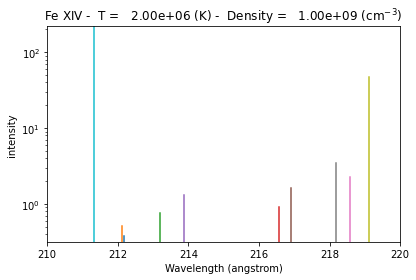

In [21]:
t = 10.**(5.8 + 0.05*np.arange(21.))
fe14 = ch.ion('fe_14', temperature=t, eDensity=1.e+9, em=1.e+27)
fe14.intensityPlot(wvlRange=[210.,220.],linLog='log')

## Wiener filtering with a rectangular impulse response

As a first example, let's suppose that the impulse response is $h(x)={\rm rect} (\frac{x}{\Delta})$, in which case ${\hat h}(u)=
\Delta{\rm sinc} (\Delta u)$

In [155]:
def h(x,delta):
  h=bspline(x/delta,0)
  return h
def hhat(u,delta):
  h=delta*np.sinc(delta*u)
  return h
def w(u,delta, snr):
  w=np.conjugate(hhat(u,delta))*snr/((np.abs(hhat(u,delta))**2)*snr+1)
  return w

Here are plots of $h(x)$ and ${\hat h}(u)$. $|u_{max}|=\frac{1}{2\delta x}$ and $\delta u=\frac{1}{2X}$


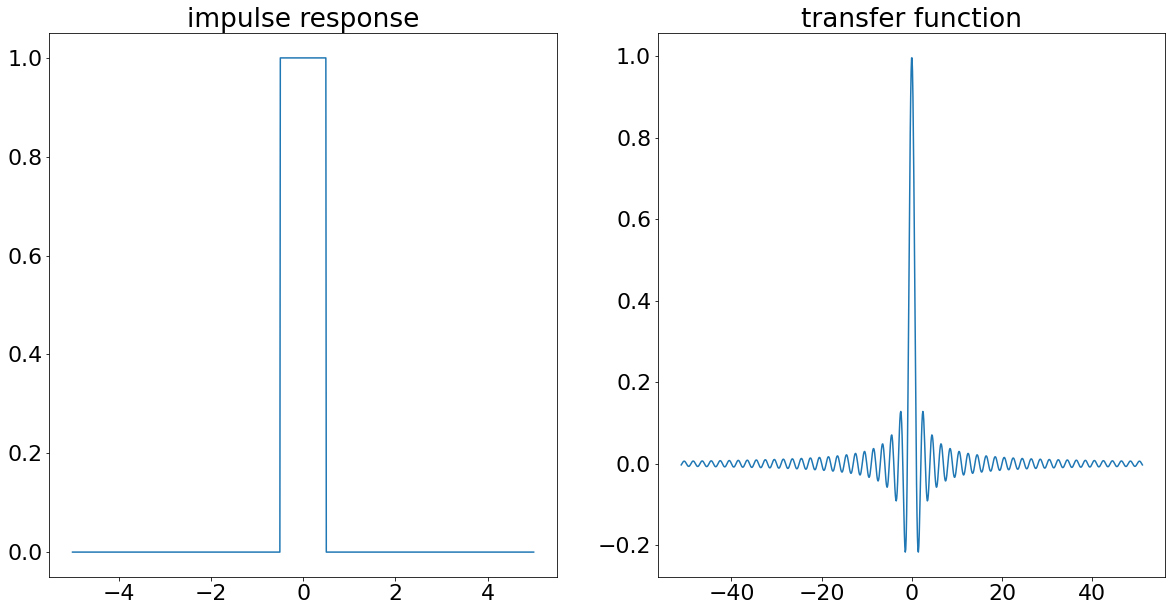

In [156]:
plt.rcParams['figure.figsize'] = [20, 10]
X=5
x=np.linspace(-X,X,1024)
deltax=x[1]-x[0]
u=np.arange(-1./(2*deltax),1./(2*deltax),1/(2*X))
plt.subplot(1,2,1)
plt.title('impulse response')
plt.plot(x,h(x,1))
plt.subplot(1,2,2)
plt.title('transfer function')
plt.plot(u,hhat(u,1))


Let's consider the effect of boxcar sampling on the atomic spectrum shown below

Text(0, 0.5, 'erg cm$^{-2}$ s$^{-1}$ sr$^{-1} \\AA^{-1}$ ')

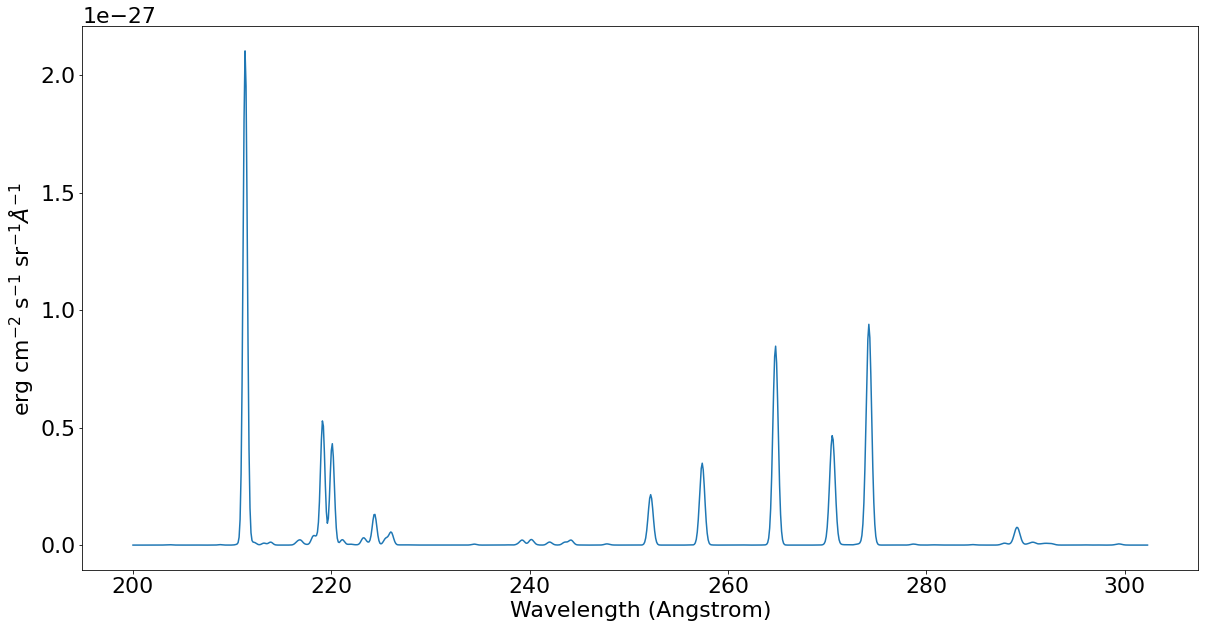

In [157]:
t = 10.**(5.8 + 0.05*np.arange(21.))
fe14 = ch.ion('fe_14', temperature=t, eDensity=1.e+9)
wvl = wvl=200. + 0.1*np.arange(1024)
fe14.spectrum(wvl)
plt.plot(wvl,fe14.Spectrum['intensity'][5,:])
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])

Here is what the measurement data would look like

Text(0, 0.5, 'erg cm$^{-2}$ s$^{-1}$ sr$^{-1} \\AA^{-1}$ ')

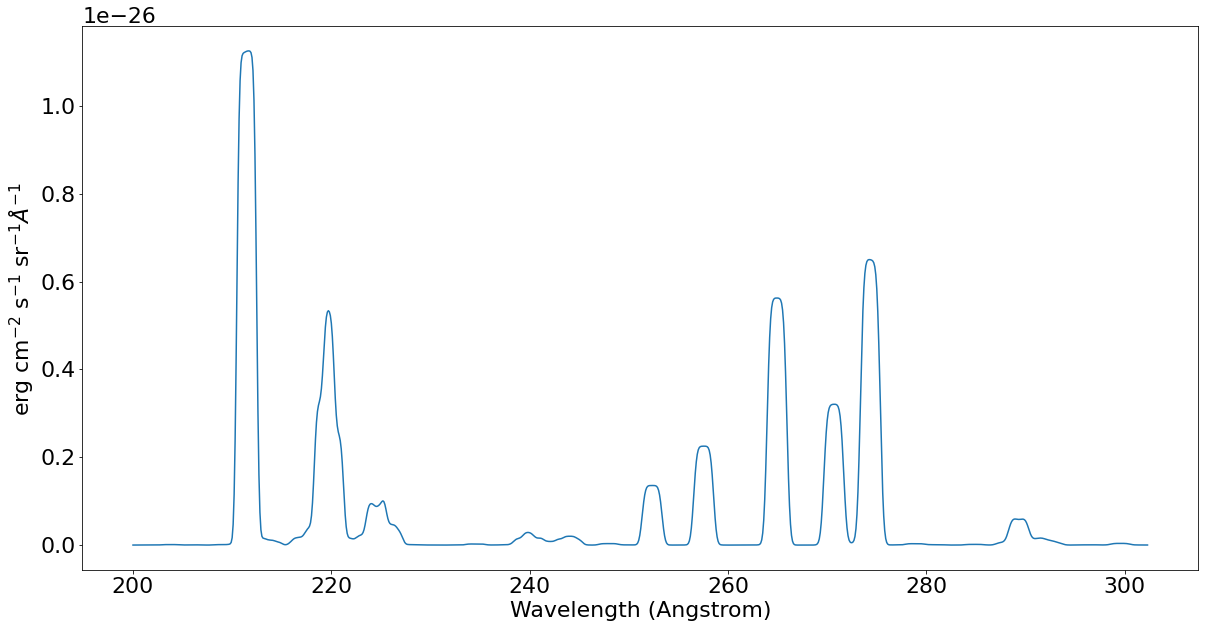

In [158]:
#need to set deltax for h the same as for the spectrum, here it is .1 angstrom
xrange=np.arange(-5,5,.1)
delta=2
g=convolve(fe14.Spectrum['intensity'][5,:],h(xrange,delta),'same')
plt.plot(wvl,g)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

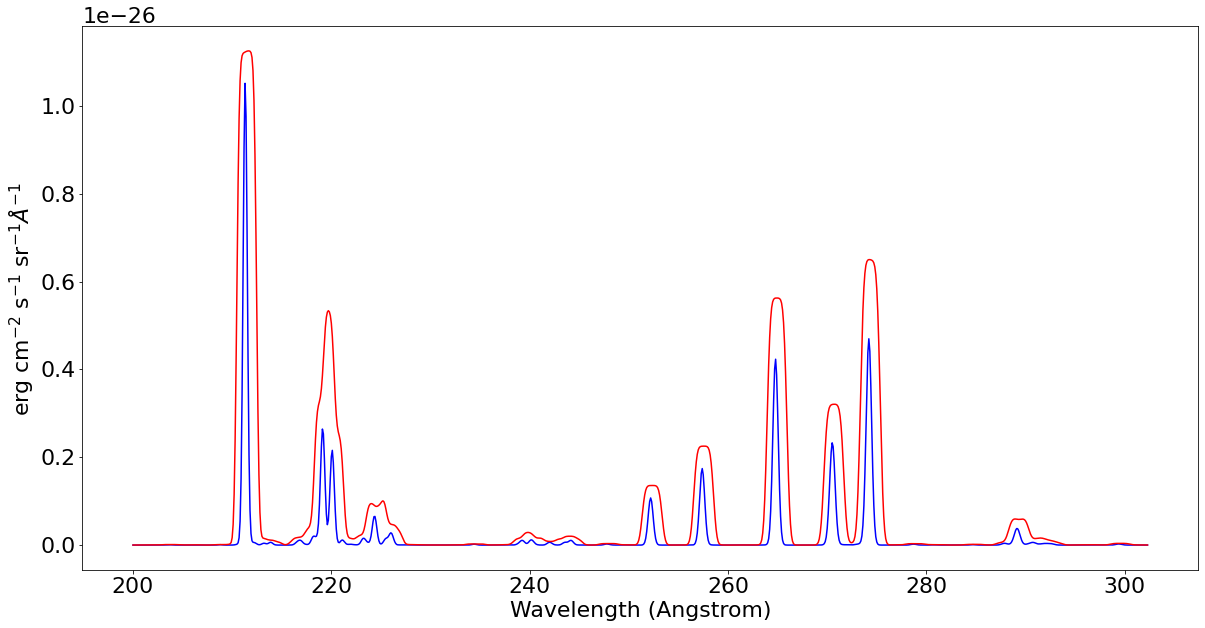

In [159]:

plt.plot(wvl,5*fe14.Spectrum['intensity'][5,:],'b',wvl,g,'r')
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.savefig('fe14Spec.pdf')
files.download('fe14Spec.pdf')

In [ ]:
np.random.normal()

 the Wiener filter can be applied to the measurements as shown here

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

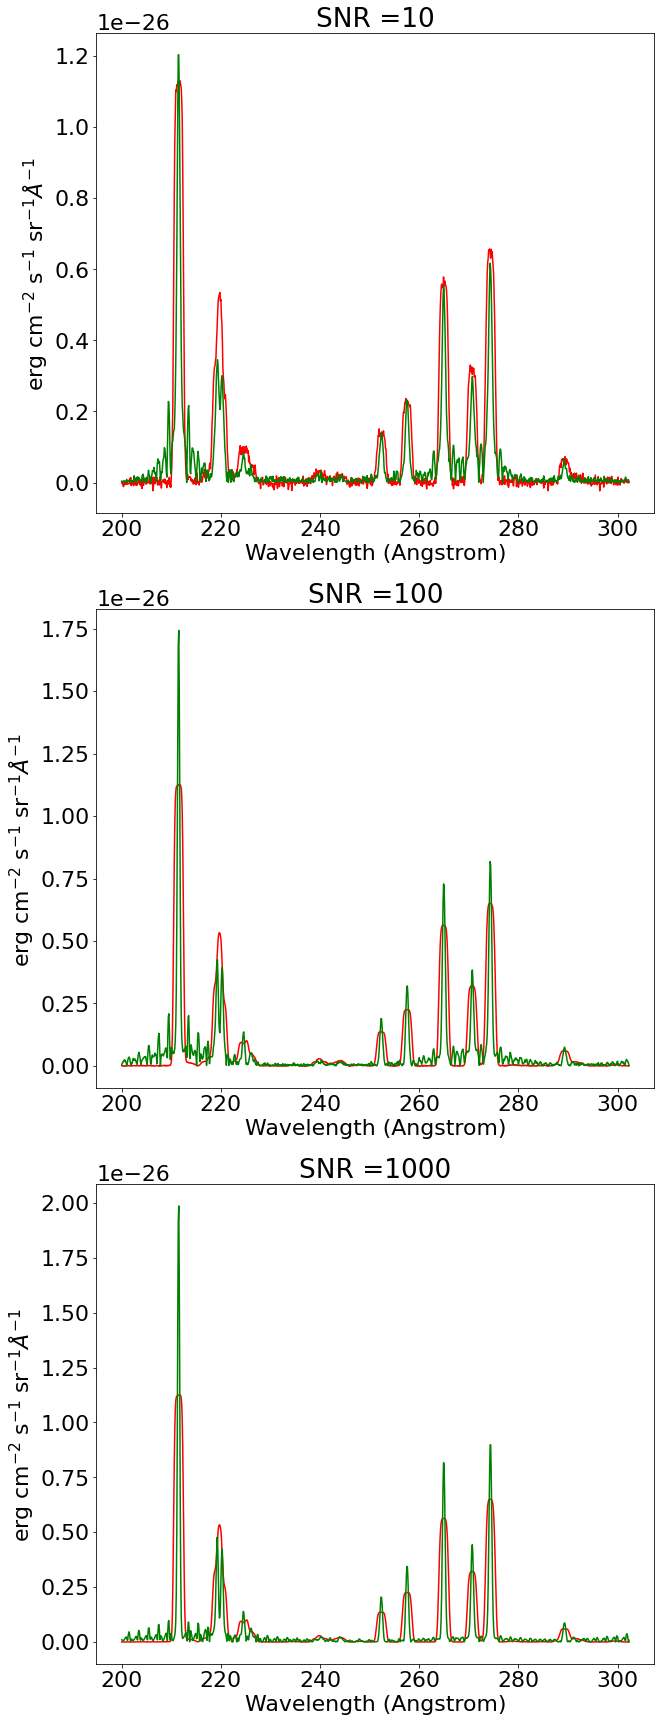

In [161]:
plt.rcParams['figure.figsize'] = [10, 30]
urange=np.arange(-1/(2*(xrange[1]-xrange[0])),1/(2*(xrange[1]-xrange[0])),1/(1024*(xrange[1]-xrange[0])))
snr=10
g10=g+np.random.normal(0,.1*np.mean(g),1024)
fest10=np.fft.ifft(w(urange,delta,snr)*np.fft.fftshift(np.fft.fft(g10)))
snr=100
g100=g+np.random.normal(0,.01*np.mean(g),1024)
fest100=np.fft.ifft(w(urange,delta,snr)*np.fft.fftshift(np.fft.fft(g100)))
snr=1000
g1000=g+np.random.normal(0,.001*np.mean(g),1024)
fest1000=np.fft.ifft(w(urange,delta,snr)*np.fft.fftshift(np.fft.fft(g1000)))
plt.subplot(3,1,1)
plt.plot(wvl,g10,'r',wvl,np.abs(fest10),'g')
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('SNR =10')
plt.subplot(3,1,2)
plt.plot(wvl,g100,'r',wvl,np.abs(fest100),'g')
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('SNR =100')
plt.subplot(3,1,3)
plt.plot(wvl,g1000,'r',wvl,np.abs(fest1000),'g')
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('SNR =1000')
plt.savefig('wienerFiltered.pdf')
files.download('wienerFiltered.pdf')


## Wiener filtering with a cubic spline impulse response

 let's suppose that the impulse response is $h(x)={\rm cubicSpline} (\frac{x}{\Delta})$

In [132]:
xrange=wvl-np.mean(wvl)
urange=np.arange(-1/(2*(xrange[1]-xrange[0])),1/(2*(xrange[1]-xrange[0])),1/(1024*(xrange[1]-xrange[0])))
delta=2
h=bspline(xrange/delta,3)
hhat=np.fft.fftshift(np.fft.fft(np.fft.fftshift(h)))
def w(hhat, snr):
  w=np.conjugate(hhat)*snr/((np.abs(hhat)**2)*snr+1)
  return w

Here are plots of $h(x)$ and ${\hat h}(u)$. $|u_{max}|=\frac{1}{2\delta x}$ and $\delta u=\frac{1}{2X}$


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


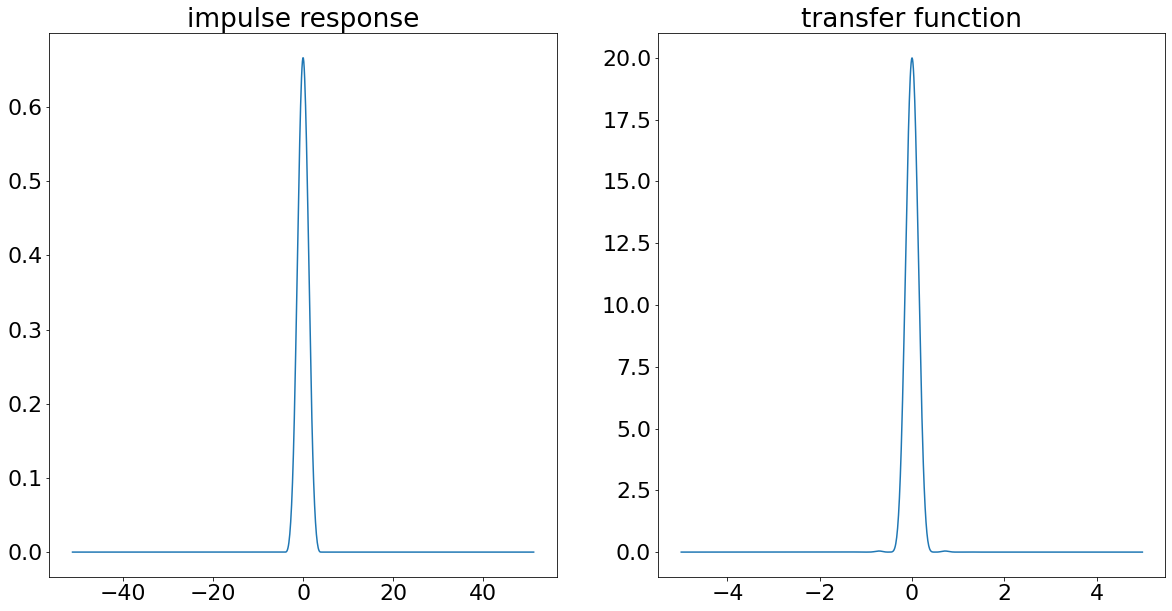

In [133]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,2,1)
plt.title('impulse response')
plt.plot(xrange,h)
plt.subplot(1,2,2)
plt.title('transfer function')
plt.plot(urange,hhat)


Let's consider the effect of boxcar sampling on the atomic spectrum shown below

Text(0, 0.5, 'erg cm$^{-2}$ s$^{-1}$ sr$^{-1} \\AA^{-1}$ ')

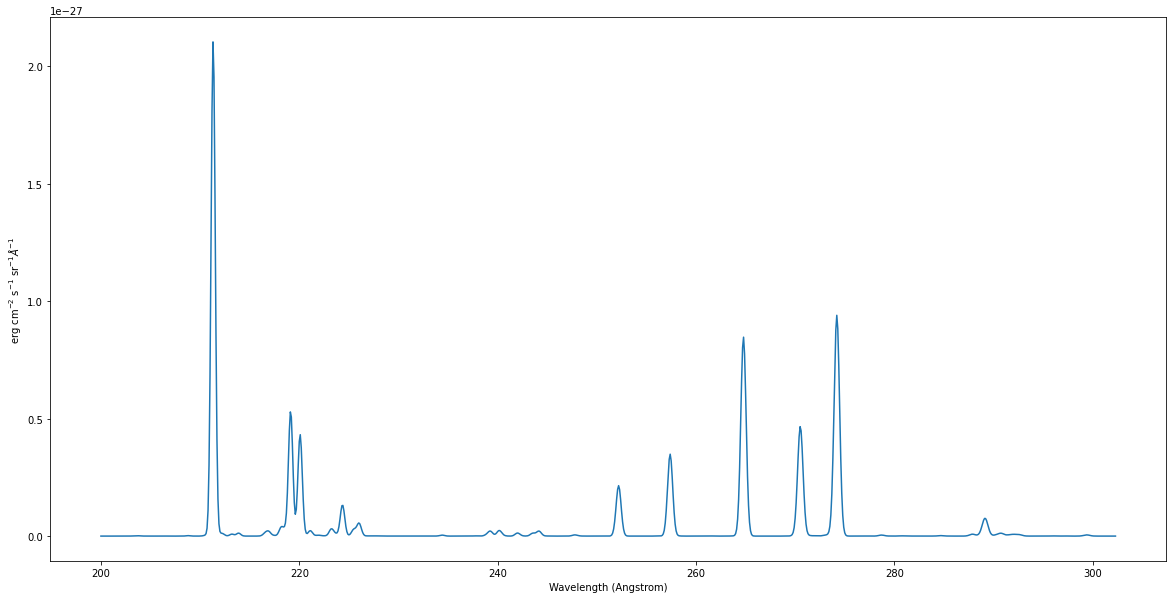

In [ ]:
t = 10.**(5.8 + 0.05*np.arange(21.))
fe14 = ch.ion('fe_14', temperature=t, eDensity=1.e+9)
wvl = wvl=200. + 0.1*np.arange(1024)
fe14.spectrum(wvl)
plt.plot(wvl,fe14.Spectrum['intensity'][5,:])
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])

Here is what the measurement data would look like

Text(0, 0.5, 'erg cm$^{-2}$ s$^{-1}$ sr$^{-1} \\AA^{-1}$ ')

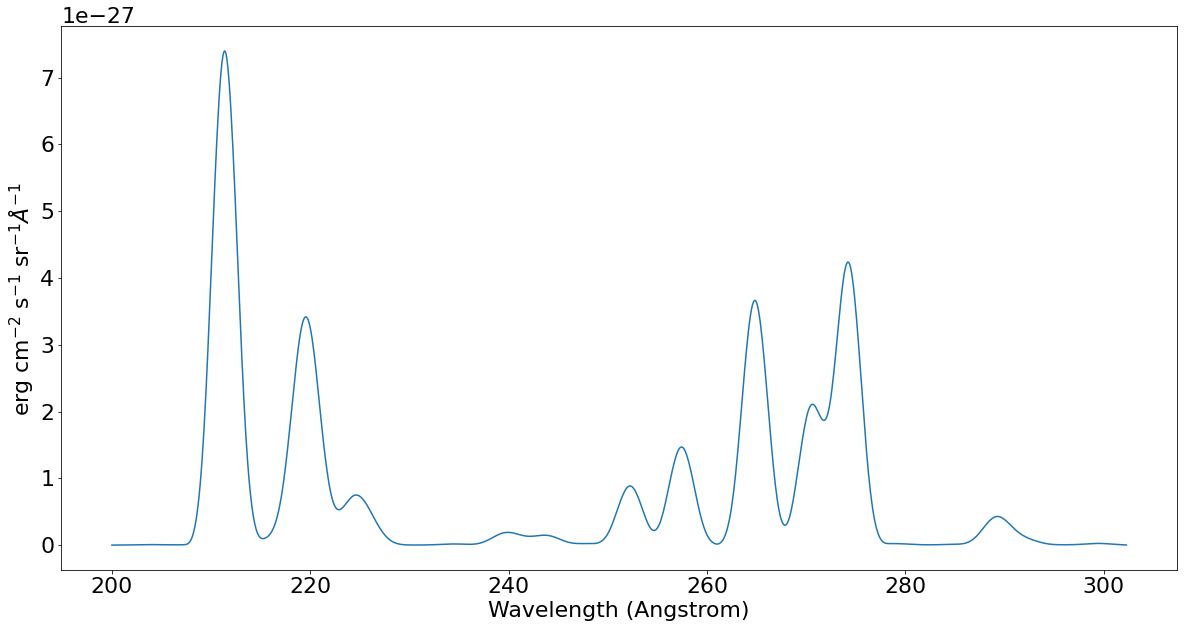

In [134]:
#need to set deltax for h the same as for the spectrum, here it is .1 angstrom
xrange=np.arange(-5,5,.1)
delta=2
g=convolve(fe14.Spectrum['intensity'][5,:],h,'same')
plt.plot(wvl,g)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])

Text(0, 0.5, 'erg cm$^{-2}$ s$^{-1}$ sr$^{-1} \\AA^{-1}$ ')

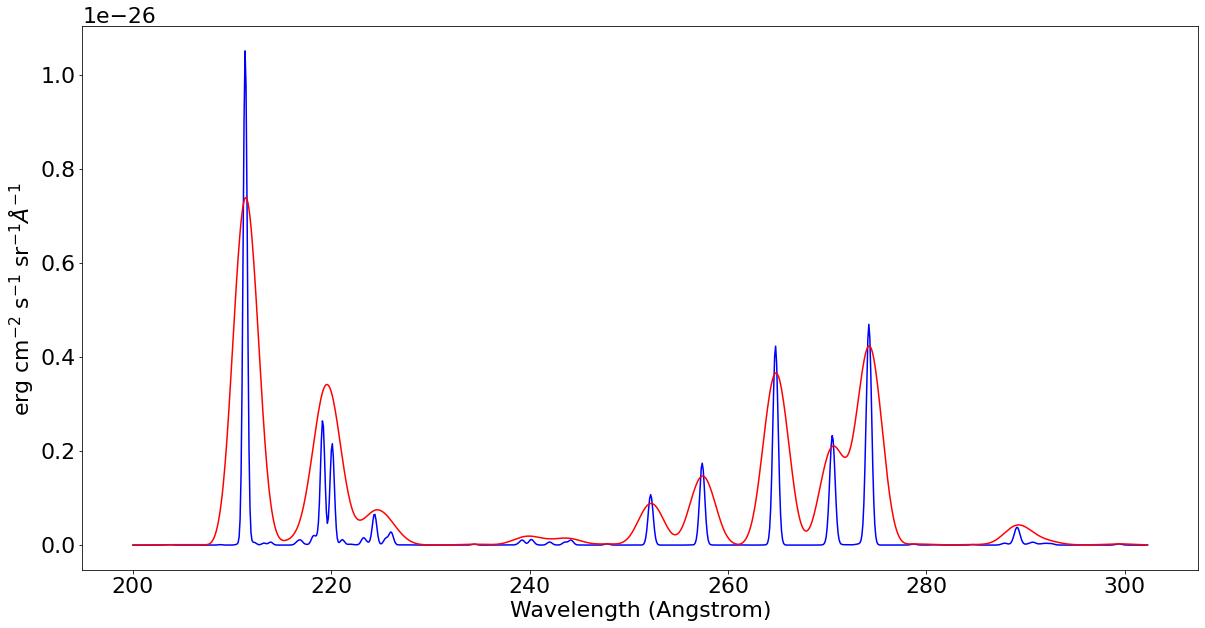

In [135]:

plt.plot(wvl,5*fe14.Spectrum['intensity'][5,:],'b',wvl,g,'r')
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])

 the Wiener filter can be applied to the measurements as shown here

Text(0.5, 1.0, 'SNR =1000')

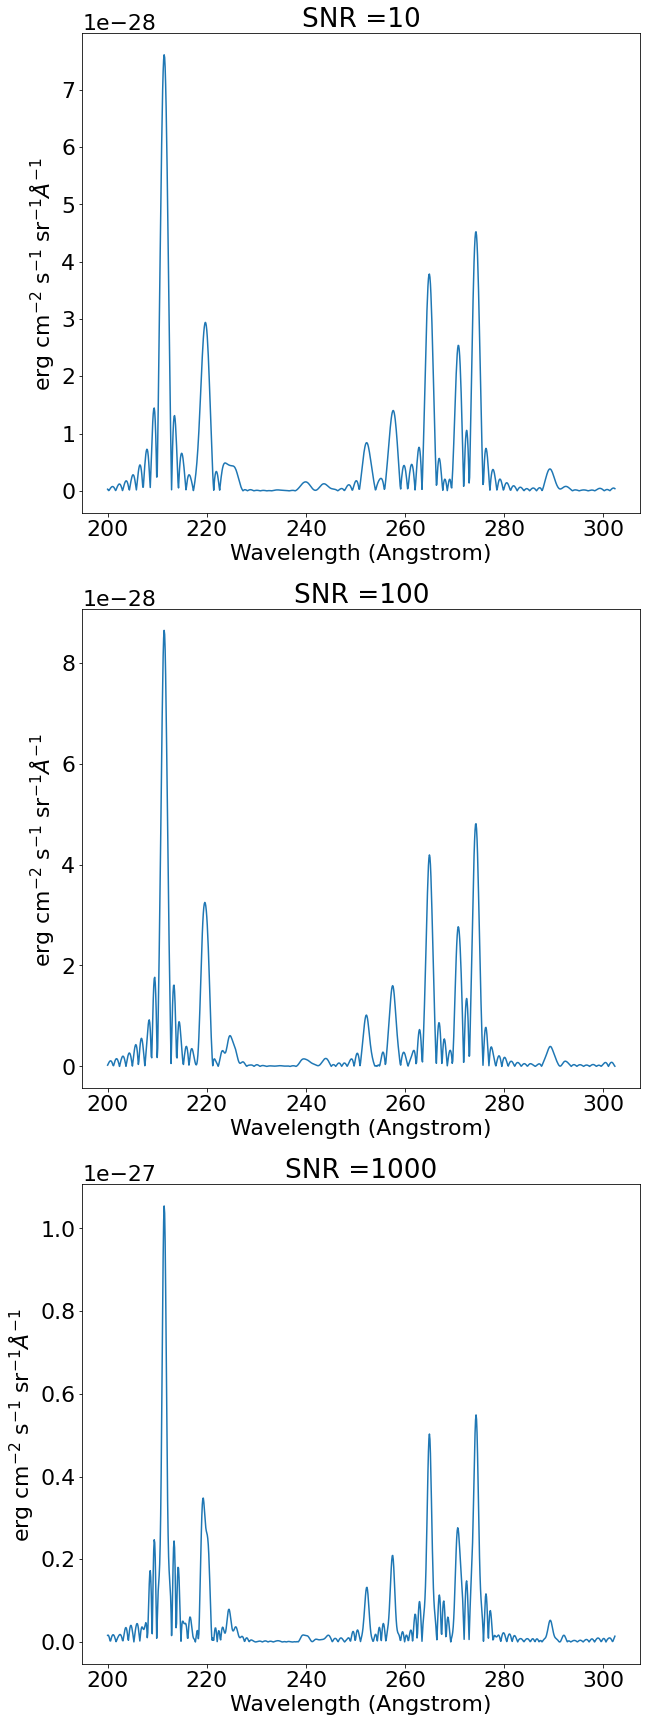

In [136]:
plt.rcParams['figure.figsize'] = [10, 30]
snr=10
fest10=np.fft.ifft(w(hhat,snr)*np.fft.fftshift(np.fft.fft(g)))
snr=100
fest100=np.fft.ifft(w(hhat,snr)*np.fft.fftshift(np.fft.fft(g)))
snr=1000
fest1000=np.fft.ifft(w(hhat,snr)*np.fft.fftshift(np.fft.fft(g)))
plt.subplot(3,1,1)
plt.plot(wvl,np.abs(fest10))
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('SNR =10')
plt.subplot(3,1,2)
plt.plot(wvl,np.abs(fest100))
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('SNR =100')
plt.subplot(3,1,3)
plt.plot(wvl,np.abs(fest1000))
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('SNR =1000')


## Wiener Filtering of 2D images

Here we apply the Wiener filter to restoration of 2D images. Consider the following original image.

In [178]:
!wget https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/blob/8121b5643de8531f76d661c0fc9b70e5ad176950/images/snake.npy

--2021-05-31 23:48:45--  https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/blob/8121b5643de8531f76d661c0fc9b70e5ad176950/images/snake.npy
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘snake.npy.1’

snake.npy.1             [ <=>                ] 111.01K  --.-KB/s    in 0.01s   

2021-05-31 23:48:46 (7.24 MB/s) - ‘snake.npy.1’ saved [113679]



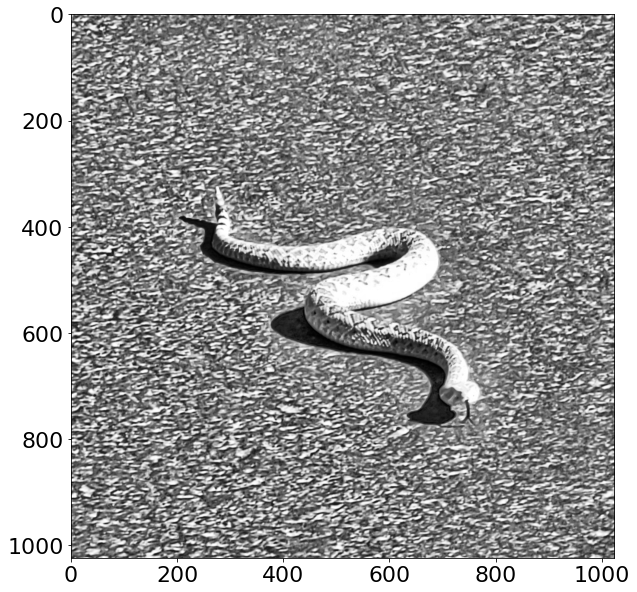

In [215]:
snake=np.load('snake.npy')
snake=exposure.equalize_adapthist(snake)
plt.imshow(snake,cmap='gray')

The image may be degraded by the psf on sampling

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

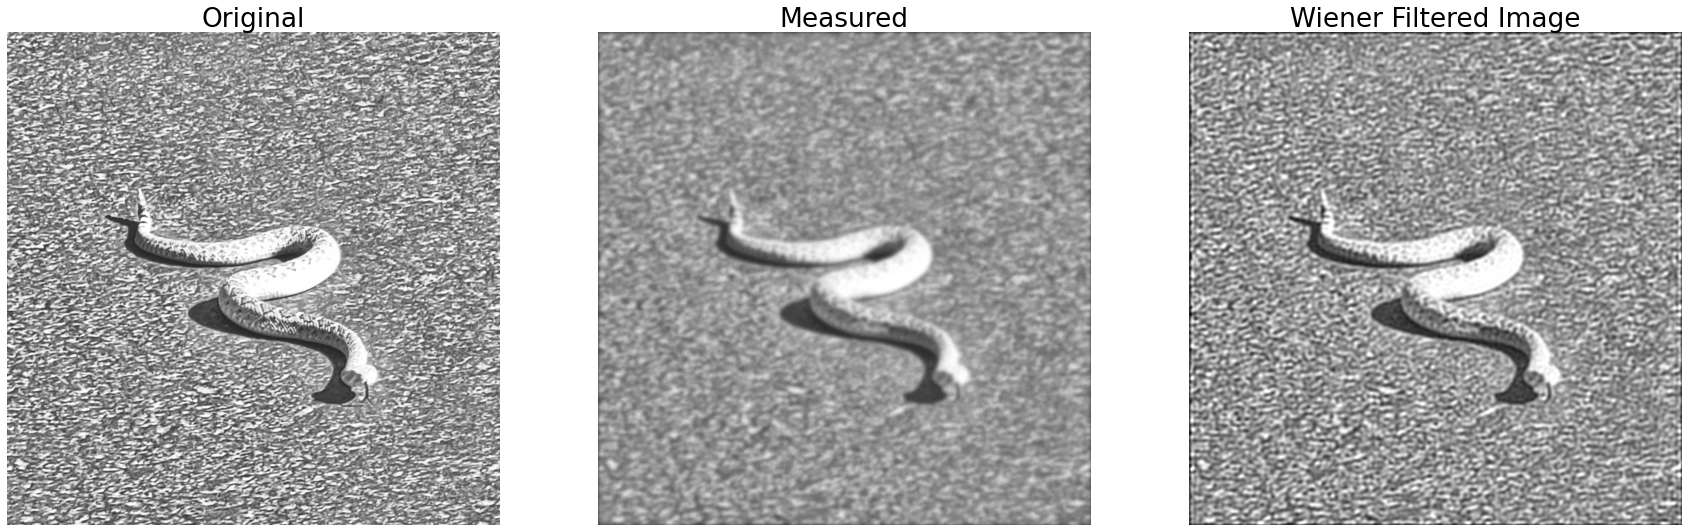

In [217]:
# convolve with sampling psf
snr=10
xrange=np.linspace(-3,3,32)
x,y=np.meshgrid(xrange,xrange)
psf = np.exp(-(x**2+y**2))
psf=psf/np.sum(np.sum(psf))
snaked = convolve2d(snake, psf, 'same')
#add noise
snaked += snake.std() * np.random.standard_normal(snake.shape)/snr

deconvolved = restoration.wiener(snaked, psf,1/snr)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(snake, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(snaked, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[1].axis('off')
ax[1].set_title('Measured')
ax[2].imshow(deconvolved)
ax[2].axis('off')
ax[2].set_title('Wiener Filtered Image')
plt.savefig('snakeWiener.pdf')
files.download('snakeWiener.pdf')


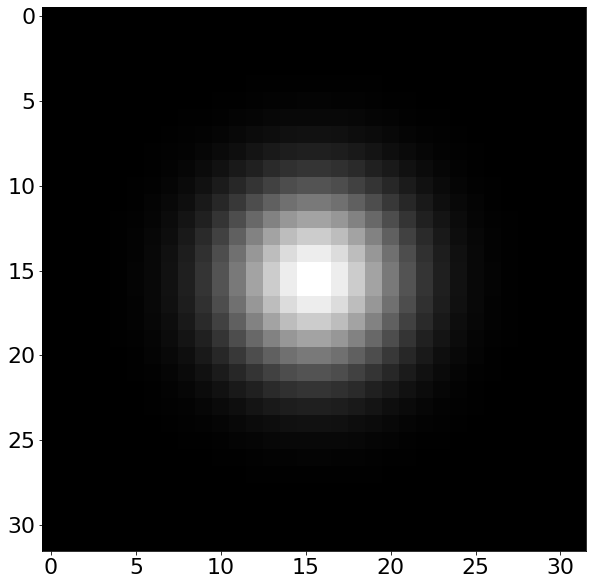

In [214]:
plt.imshow(psf)